In [1]:
import pandas as pd
import numpy as np


In [2]:
from typing import cast
from tesi.database.di import get_session_maker
from tesi.zappai.di import (
    get_cds_api,
    get_climate_generative_model_repository,
    get_future_climate_data_repository,
    get_location_repository,
    get_past_climate_data_repository,
)
from tesi.zappai.repositories.dtos import ClimateDataDTO, FutureClimateDataDTO, LocationDTO
from tesi.zappai.utils import common


session_maker = get_session_maker()
cds_api = get_cds_api()
location_repository = get_location_repository(session_maker=session_maker)
past_climate_data_repository = get_past_climate_data_repository(
    session_maker=session_maker,
    cds_api=cds_api,
    location_repository=location_repository,
)
future_climate_data_repository = get_future_climate_data_repository(
    session_maker=session_maker, cds_api=cds_api
)
climate_generative_model_repository = get_climate_generative_model_repository(
    session_maker=session_maker,
    location_repository=location_repository,
    past_climate_data_repository=past_climate_data_repository,
    future_climate_data_repository=future_climate_data_repository,
)

location = await location_repository.get_location_by_country_and_name(
    country=common.EXAMPLE_LOCATION_COUNTRY, name=common.EXAMPLE_LOCATION_NAME
)
if location is None:
    location = await location_repository.create_location(
        country=common.EXAMPLE_LOCATION_COUNTRY,
        name=common.EXAMPLE_LOCATION_NAME,
        longitude=common.EXAMPLE_LONGITUDE,
        latitude=common.EXAMPLE_LATITUDE,
    )
past_climate_data_df = ClimateDataDTO.from_list_to_dataframe(
    await past_climate_data_repository.get_past_climate_data(location.id)
)
future_climate_data_df = FutureClimateDataDTO.from_list_to_dataframe(
    await future_climate_data_repository.get_future_climate_data_for_nearest_coordinates(
        longitude=location.longitude,
        latitude=location.latitude,
        start_year=1970,
        start_month=1,
    )
)

location = cast(LocationDTO, location)

2024-06-12 00:40:43.702529: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-12 00:40:43.705157: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-12 00:40:43.737268: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 00:40:44.395021: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
await climate_generative_model_repository.delete_climate_generative_model(
    location_id=location.id
)
climate_generative_model = (
    await climate_generative_model_repository.create_model_for_location(location.id)
)
model = climate_generative_model.model
x_scaler = climate_generative_model.x_scaler
y_scaler = climate_generative_model.y_scaler

Epoch 1/50


/home/peppeosmio/Progetti/tesi/.venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/peppeosmio/Progetti/tesi/.venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/peppeosmio/Progetti/tesi/.venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/peppeosmio/Progetti/tesi/.venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/peppeosmio/Progetti/tesi/.venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/peppeosmio/Progetti/tesi/.venv/lib/python3.1

22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.2092 - root_mean_squared_error: 1.0979 - val_loss: 0.9496 - val_root_mean_squared_error: 0.9745
Epoch 2/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0479 - root_mean_squared_error: 1.0234 - val_loss: 0.8130 - val_root_mean_squared_error: 0.9017
Epoch 3/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8924 - root_mean_squared_error: 0.9440 - val_loss: 0.6923 - val_root_mean_squared_error: 0.8320
Epoch 4/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7605 - root_mean_squared_error: 0.8718 - val_loss: 0.5825 - val_root_mean_squared_error: 0.7632
Epoch 5/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.6008 - root_mean_squared_error: 0.7748 - val_loss: 0.4802 - val_root_mean_squared_error: 0.6930
Epoch 6/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.5238 - root_mean_squared_error: 0.7237 - val_loss: 0.3880 - val_root_mean_squared_error: 0.6229
Epoch 7/50
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.4370 - root_me

In [4]:
from tesi.zappai.repositories.climate_generative_model_repository import (
    ClimateGenerativeModelRepository,
)


df_test = ClimateDataDTO.from_list_to_dataframe(
    await past_climate_data_repository.get_past_climate_data(
        location_id=location.id,
        year_from=climate_generative_model.test_start_year,
        month_from=climate_generative_model.test_start_month,
        year_to=climate_generative_model.test_end_year,
        month_to=climate_generative_model.test_end_month,
    )
)

df_test = ClimateGenerativeModelRepository.add_sin_cos_year(df_test)

In [5]:
x_df_test = df_test[ClimateGenerativeModelRepository.get_features()]
x_df_test

soil_temperature_level_3  volumetric_soil_water_layer_3  sin_year  \
year month                                                                      
2011 10                   293.741419                       0.152529 -1.000000   
     11                   289.806455                       0.162347 -0.866025   
     12                   286.558917                       0.191056 -0.500000   
2012 1                    283.667371                       0.203387  0.000000   
     2                    282.454511                       0.240692  0.500000   
...                              ...                            ...       ...   
2024 1                    285.878260                       0.182360  0.000000   
     2                    285.261142                       0.178380  0.500000   
     3                    286.256922                       0.196695  0.866025   
     4                    288.858824                       0.190879  1.000000   
     5                    291.249895                       0.173759  0.866025   

                cos_year  10m_u_component_of_wind  10m_v_component_of_wind  \
year month                                                                   
2011 10    -1.836970e-16                 0.461430                -1.141662   
     11     5.000000e-01                -0.181396                -0.330990   
     12     8.660254e-01                 1.268430                -0.125131   
2012 1      1.000000e+00                 1.721778                -1.836420   
     2      8.660254e-01                 1.043455                -1.545993   
...                  ...                      ...                      ...   
2024 1      1.000000e+00                 1.464902                -0.637662   
     2      8.660254e-01                 0.564335                 0.520767   
     3      5.000000e-01                 0.811452                 0.963794   
     4      6.123234e-17                 0.760184                 0.400504   
     5     -5.000000e-01                 0.367084                 0.532176   

            2m_temperature  evaporation  total_precipitation  \
year month                                                     
2011 10         290.862260    -0.003017             0.001613   
     11         287.150551    -0.001732             0.003173   
     12         284.456450    -0.001938             0.001412   
2012 1          281.515102    -0.002350             0.001162   
     2          280.743743    -0.002333             0.006076   
...                    ...          ...                  ...   
2024 1          284.485659    -0.001723             0.001416   
     2          285.610095    -0.001290             0.002229   
     3          286.796737    -0.001775             0.000971   
     4          289.575987    -0.002236             0.001208   
     5          292.594924    -0.002159             0.001128   

            surface_pressure  surface_solar_radiation_downwards  \
year month                                                        
2011 10        100051.252778                       1.192052e+07   
     11        100361.739811                       7.867499e+06   
     12        100000.368555                       6.771313e+06   
2012 1         100035.258620                       8.295657e+06   
     2          99683.801669                       8.984526e+06   
...                      ...                                ...   
2024 1         100015.995353                       7.378288e+06   
     2          99883.250332                       1.103211e+07   
     3          99534.306838                       1.623242e+07   
     4          99752.446554                       2.111158e+07   
     5          99560.803809                       2.225734e+07   

            surface_thermal_radiation_downwards  
year month                                       
2011 10                            2.856999e+07  
     11                            2.756182e+07  
     12                            2.5

In [6]:
y_df_test = df_test[ClimateGenerativeModelRepository.get_target()]
y_df_test

soil_temperature_level_3  volumetric_soil_water_layer_3
year month                                                         
2011 10                   293.741419                       0.152529
     11                   289.806455                       0.162347
     12                   286.558917                       0.191056
2012 1                    283.667371                       0.203387
     2                    282.454511                       0.240692
...                              ...                            ...
2024 1                    285.878260                       0.182360
     2                    285.261142                       0.178380
     3                    286.256922                       0.196695
     4                    288.858824                       0.190879
     5                    291.249895                       0.173759

[152 rows x 2 columns]

In [7]:
from typing import cast

from tesi.zappai.repositories.climate_generative_model_repository import ClimateGenerativeModelRepository


x_test_scaled = cast(np.ndarray, x_scaler.transform(x_df_test))
y_test_scaled = cast(np.ndarray, y_scaler.transform(y_df_test))

x_test_formatted, y_test_formatted = ClimateGenerativeModelRepository.format_data(x=x_test_scaled, y=y_test_scaled)
x_test_formatted.shape, y_test_formatted.shape

/home/peppeosmio/Progetti/tesi/.venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(
/home/peppeosmio/Progetti/tesi/.venv/lib/python3.10/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


((140, 12, 12), (140, 2))

In [8]:
predictions = model.predict(x_test_formatted)
inverse_scaled_predictions = cast(np.ndarray, y_scaler.inverse_transform(predictions))
predictions_df = pd.DataFrame(data=inverse_scaled_predictions, columns=ClimateGenerativeModelRepository.get_target())
y_df_plot = y_df_test[:-ClimateGenerativeModelRepository.get_seq_length()].copy().reset_index()
for target in ClimateGenerativeModelRepository.get_target():
    y_df_plot[f"predicted_{target}"] = predictions_df[target]
y_df_plot = y_df_plot.set_index(keys=["year", "month"], drop=True)
y_df_plot

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


soil_temperature_level_3  volumetric_soil_water_layer_3  \
year month                                                            
2011 10                   293.741419                       0.152529   
     11                   289.806455                       0.162347   
     12                   286.558917                       0.191056   
2012 1                    283.667371                       0.203387   
     2                    282.454511                       0.240692   
...                              ...                            ...   
2023 1                    285.572046                       0.226733   
     2                    283.689941                       0.237788   
     3                    285.351573                       0.230490   
     4                    286.302789                       0.222583   
     5                    289.332086                       0.242591   

            predicted_soil_temperature_level_3  \
year month                                       
2011 10                             292.497314   
     11                             288.816589   
     12                             285.400299   
2012 1                              282.577332   
     2                              281.850616   
...                                        ...   
2023 1                              283.407135   
     2                              282.734436   
     3                              284.131561   
     4                              286.639587   
     5                              290.077515   

            predicted_volumetric_soil_water_layer_3  
year month                                           
2011 10                                    0.163984  
     11                                    0.171008  
     12                                    0.200713  
2012 1                                     0.210195  
     2                                     0.225064  
...                                             ...  
2023 1                                     0.196357  
     2                                     0.203188  
     3                                     0.207048  
     4                                     0.198829  
     5                                     0.185609  

[140 rows x 4 columns]

<Axes: xlabel='year,month'>

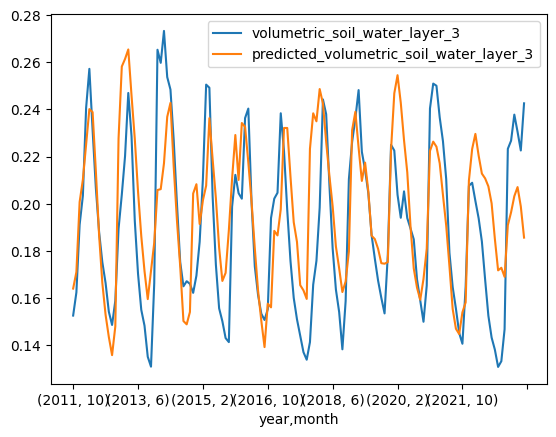

In [9]:
y_df_plot[["volumetric_soil_water_layer_3", "predicted_volumetric_soil_water_layer_3"]].plot()

<Axes: xlabel='year,month'>

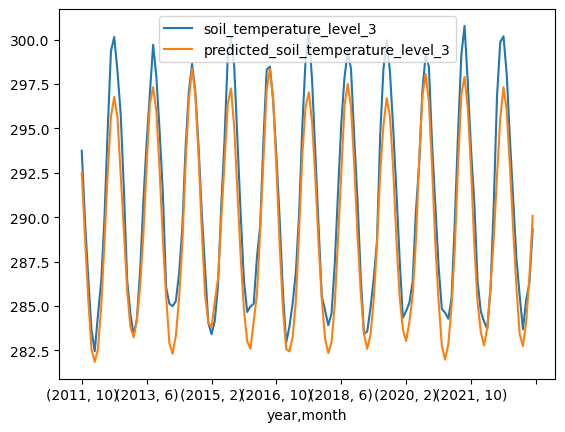

In [10]:
y_df_plot[["soil_temperature_level_3", "predicted_soil_temperature_level_3"]].plot()

In [16]:
generated_data = await climate_generative_model_repository.generate_climate_data_from_last_past_climate_data(
    location_id=location.id # type: ignore
)
generated_data = generated_data[:12]
generated_data

(55, 12)
(55, 10)


soil_temperature_level_3  volumetric_soil_water_layer_3  \
year month                                                            
2024 6                    293.776367                       0.173977   
     7                    290.073364                       0.143486   
     8                    287.784119                       0.123877   
     9                    286.701324                       0.107482   
     10                   285.971436                       0.098513   
     11                   286.143585                       0.088338   
     12                   286.464203                       0.082906   
2025 5                    286.674133                       0.080107   
     6                    285.759186                       0.087825   
     7                    286.106262                       0.086890   
     8                    285.612793                       0.088206   
     9                    285.525391                       0.086008   

                sin_year      cos_year  10m_u_component_of_wind  \
year month                                                        
2024 6      5.000000e-01 -8.660254e-01                 1.453670   
     7      1.224647e-16 -1.000000e+00                 0.558910   
     8     -5.000000e-01 -8.660254e-01                 0.563675   
     9     -8.660254e-01 -5.000000e-01                 0.274924   
     10    -1.000000e+00 -1.836970e-16                -0.105953   
     11    -8.660254e-01  5.000000e-01                 1.418953   
     12    -5.000000e-01  8.660254e-01                 1.879587   
2025 5      8.660254e-01 -5.000000e-01                -0.774936   
     6      5.000000e-01 -8.660254e-01                 1.599512   
     7      1.224647e-16 -1.000000e+00                 1.944831   
     8     -5.000000e-01 -8.660254e-01                 1.091253   
     9     -8.660254e-01 -5.000000e-01                 0.059841   

            10m_v_component_of_wind  2m_temperature  evaporation  \
year month                                                         
2024 6                    -0.767491      296.334045     0.000013   
     7                    -1.967647      301.334106     0.000014   
     8                    -1.132628      301.673767     0.000020   
     9                    -0.889209      296.034058     0.000031   
     10                   -0.337615      292.686401     0.000020   
     11                    0.516295      288.572266     0.000030   
     12                    1.629478      286.130249     0.000026   
2025 5                    -0.577503      295.110168     0.000010   
     6                     0.314960      297.919189     0.000017   
     7                    -0.855374      300.765564     0.000020   
     8                    -0.696286      303.317505     0.000016   
     9                    -1.141844      299.484070     0.000018   

            total_precipitation  surface_pressure  \
year month                                          
2024 6                 0.000042     100727.203125   
     7                 0.000124     100769.820312   
     8                 0.000468     100933.125000   
     9                 0.000696     101335.507812   
     10                0.000205     101775.375000   
     11                0.001186     101814.765625   
     12                0.001765     101981.500000   
2025 5                 0.000271     101174.890625   
     6                 0.001075     100441.601562   
     7                 0.000446     100505.960938   
     8                 0.000032     100749.546875   
     9                 0.000038     101191.226562   

            surface_solar_radiation_downwards  \
year month                                      
2024 6                             317.720551   
     7                             334.415070   
     8                             296.527100   
     9                             221.370544   
     10                            175.507004   
     11                            100.

In [12]:
from tesi.zappai.repositories.climate_generative_model_repository import ClimateGenerativeModelRepository


# start generating from 1 year ago
seed_data = past_climate_data_df[(-12 - ClimateGenerativeModelRepository.get_seq_length()) : -12]
start_year, start_month = seed_data.index[-1]

filtered_future_climate_data_df = future_climate_data_df[
    ((future_climate_data_df.index.get_level_values("year") > start_year))
    | (
        (future_climate_data_df.index.get_level_values("year") == start_year)
        & (future_climate_data_df.index.get_level_values("month") > start_month)
    )
]

# this generated data start from one year ago
generated_data_df = climate_generative_model_repository.generate_data_from_seed(
    model=model,
    x_scaler=x_scaler,
    y_scaler=y_scaler,
    seed_data=seed_data,
    future_climate_data_df=filtered_future_climate_data_df,
)
true_data_df = past_climate_data_df[-12:]

In [13]:
from matplotlib import pyplot as plt

def plot_values(df: pd.DataFrame, values: list[str]):
    df_reset = df.reset_index()
    df_reset["YYYY-MM"] = (
        df_reset["year"].astype(str) + "-" + df_reset["month"].astype(str).str.zfill(2)
    )
    df_reset.plot(
        x="YYYY-MM",
        y=values,
        marker="o",
    )
    plt.xlabel("Month")
    plt.ylabel("Values")
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

/tmp/ipykernel_297037/4066554255.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  true_data_df["cmip5_2m_temperature"] = filtered_future_climate_data_df[:12]["2m_temperature"]


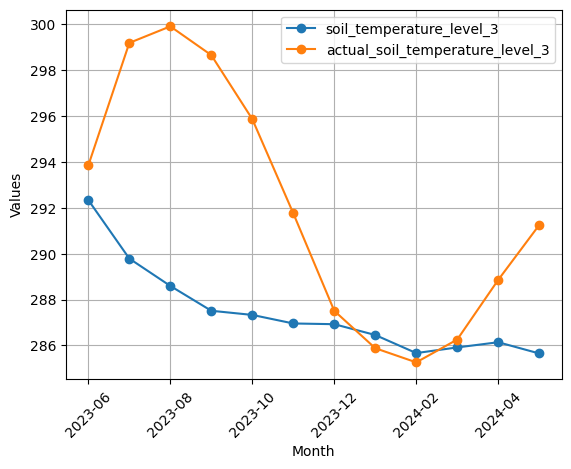

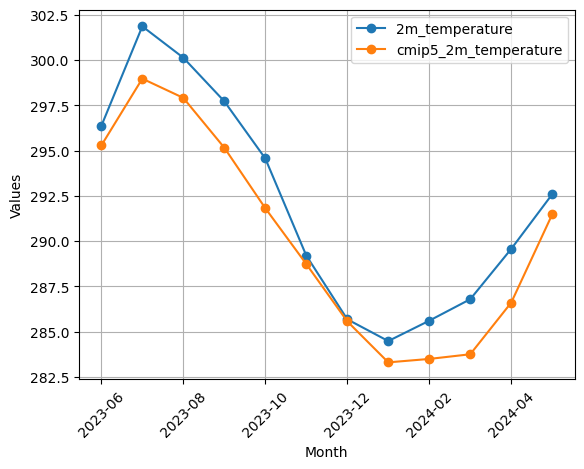

In [14]:
generated_data_df = generated_data_df[:12]
generated_data_df["actual_soil_temperature_level_3"] = true_data_df["soil_temperature_level_3"]
true_data_df["cmip5_2m_temperature"] = filtered_future_climate_data_df[:12]["2m_temperature"]
plot_values(df=generated_data_df, values=["soil_temperature_level_3", "actual_soil_temperature_level_3"])
plot_values(df=true_data_df, values=["2m_temperature", "cmip5_2m_temperature"])